In [12]:
import pyro
import torch
import matplotlib
import matplotlib.pyplot as plt
import pyro.distributions as dist
import torch.distributions.constraints as constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms

## Get the MNIST data

In [13]:
data = datasets.MNIST('/Users/tdn/Cloud/OneDrive - Aalborg Universitet/Source/Teaching/PhD-courses/probabilistic.ai/Day3/Python/data', train=True, download=False,
                          transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))
# We only select the digits 0, 1, and 2 and only the first 100 of each of these
# digits
selector = np.array([], dtype=int)
for i in [0, 1, 2]:
    selector = np.concatenate((selector, np.where(data.train_labels == i)[0][:100]))
data.train_data = data.train_data[selector, :, :]
data.train_labels = data.train_labels[selector]

# Binarize the data
data.train_data[data.train_data<128] = 0
data.train_data[data.train_data>=128] = 1

data.train_data = data.train_data.type(torch.float)
data.train_data = data.train_data.reshape(300,-1)

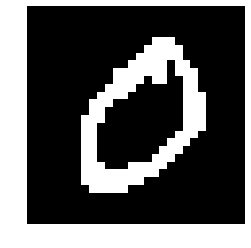

In [14]:
def display_image(x):
    plt.axis('off')
    plt.imshow(x.reshape((28, 28)), cmap="gray")

toy_image = data.train_data[0,:]
display_image(toy_image)

In [15]:
def model(data, no_attributes, no_latent):

    with pyro.plate("w_decomp", no_attributes):
        w = pyro.sample("w", dist.Normal(torch.zeros(no_latent)*0., 1.).to_event(1))
    with pyro.plate('local', len(data)):
        z = pyro.sample("z", dist.Normal(torch.zeros(no_latent, dtype=torch.float), 1.).to_event(1))
        x = pyro.sample("x", dist.Binomial(logits = torch.mm(z, torch.t(w))).to_event(1), obs=data)

    return x

In [16]:
def guide(data, no_attributes, no_latent):

    z_loc = pyro.param("z_loc", torch.zeros((len(data), no_latent), dtype=torch.float))
    z_scale = pyro.param("z_scale", torch.ones((len(data), no_latent), dtype=torch.float),
                         constraint=constraints.positive)
    with pyro.plate('local', len(data)):
        pyro.sample("z", dist.Normal(z_loc, z_scale).to_event(1))

    w_loc = pyro.param("w_loc", torch.zeros(no_attributes, no_latent, dtype=torch.float))
    w_scale = pyro.param("w_scale", torch.ones(no_attributes, no_latent, dtype=torch.float), constraint=constraints.positive)

    with pyro.plate("w_decomp", no_attributes) as ind:
        pyro.sample("w", dist.Normal(w_loc[ind], w_scale[ind]).to_event(1))

In [17]:
def train(svi, data, no_attr, no_latent):
    # initialize loss accumulator

    epoch_loss = svi.step(data, no_attr, no_latent)

    # return epoch loss
    normalizer_train = len(data)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

[epoch 000] average training loss: 211777.3281
[epoch 100] average training loss: 56876.3458
[epoch 200] average training loss: 55727.0555
[epoch 300] average training loss: 55682.8781
[epoch 400] average training loss: 55670.6539


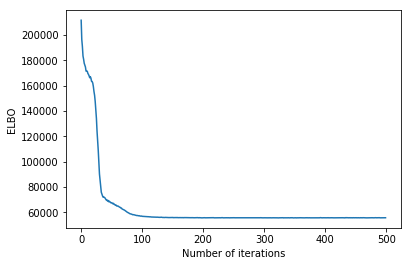

In [18]:
# Run options
LEARNING_RATE = 1.0e-1

# Run only for a single iteration for testing
NUM_EPOCHS = 500

#train_loader = setup_data_loader(batch_size=300)

# Model specifications
no_latent = 2
no_attributes = 28 * 28

# clear param store
pyro.clear_param_store()

# setup the optimizer
adam_args = {"lr": LEARNING_RATE}
optimizer = Adam(adam_args)

# setup the inference algorithm
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
train_elbo = []
# training loop
for epoch in range(NUM_EPOCHS):

    loss = svi.step(data.train_data, no_attributes, no_latent)
    train_elbo.append(loss)
    if (epoch % 100) == 0:
        print("[epoch %03d] average training loss: %.4f" % (epoch, loss))

plt.plot(range(len(train_elbo)), train_elbo)
plt.xlabel("Number of iterations")
plt.ylabel("ELBO")
plt.show()


### Learned parameters

In [19]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

z_loc tensor([[ 5.0495,  1.1019],
        [ 3.5497,  0.8246],
        [ 2.5150, -0.0830],
        [ 3.5413,  0.4464],
        [ 2.3992,  0.7497],
        [ 1.9904,  0.6896],
        [ 2.0554,  0.4791],
        [ 1.4189, -0.2261],
        [ 2.3594,  0.2576],
        [ 3.0525,  0.1764],
        [ 3.7151,  0.4813],
        [ 2.1204,  0.4340],
        [ 4.1015,  0.7457],
        [ 1.3830, -0.0065],
        [ 2.2107,  0.9691],
        [ 3.3541,  0.5239],
        [ 3.5887,  1.1963],
        [ 1.5174,  0.4749],
        [ 2.0214,  0.5146],
        [ 3.0645,  0.3292],
        [ 4.5303,  0.7954],
        [ 1.7423,  0.4367],
        [ 1.7974,  0.4772],
        [ 2.8289, -0.0190],
        [ 2.1235,  0.1831],
        [ 1.7892,  0.3864],
        [ 2.8239, -0.3442],
        [ 2.8075,  0.1666],
        [ 1.4919, -0.1093],
        [ 1.6407,  0.2196],
        [ 1.9081, -0.1120],
        [ 2.2455,  0.8838],
        [ 3.5245,  1.1594],
        [ 3.4502,  0.5138],
        [ 5.1144,  1.5487],
        [ 3.63

### Distribution in latent space

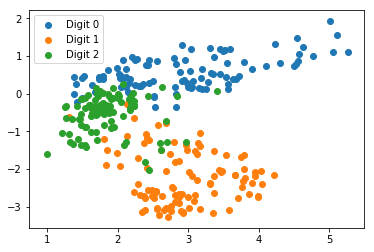

In [20]:
z_loc = pyro.param("z_loc").detach().numpy()
legends = ["Digit 0", "Digit 1", "Digit 2"]
for i in [0,1,2]:
    plt.scatter(z_loc[data.train_labels.numpy()==i,0], z_loc[data.train_labels.numpy()==i,1], label=legends[i])
plt.legend()
plt.show()